# Sparse Regression Incorporating Graphical Structure Among Predictors (SRIG), i.e. GraphLasso

In [1]:
%matplotlib inline

import pickle
import time

import numpy as np
import pandas as pd
import networkx as nx
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split, cross_val_score, KFold
def flatten(list_of_lists): return [item for sublist in list_of_lists for item in sublist]

from matplotlib_venn import venn3, venn3_circles, venn2

repo_path = '/Users/alex/Documents/gslr/'
data_path = repo_path + 'experiments/generated_data/3/'
KEGG_path = repo_path + 'experiments/KEGG/KEGG_df.filtered.with_correlates.pickle'
interactome_path = repo_path + 'experiments/algorithms/pcsf/inbiomap_temp.tsv'
pathway_id = 'hsa04110'

### I. Load Dataset

In [2]:
dataset = pd.read_csv(data_path + pathway_id + '_inbiomap_exp.csv', index_col=0)
dataset.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa04110,0.0,0.115272,-0.365345,-0.014955,-0.374350,0.109953,-0.0,-0.313725,0.034973,-0.309654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,-0.138520,-0.340004,0.430427,0.618810,-0.400398,-0.0,0.281479,-0.903482,0.312078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.492418,0.612346,0.544840,-0.253648,-0.004268,-0.0,-0.109864,0.337787,-0.604446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,-0.592521,0.050179,0.383061,0.261450,-0.131206,0.0,-0.265055,0.179607,-0.416877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,0.0,0.000973,0.040952,-0.728286,-0.604990,-0.119933,-0.0,-0.047649,0.165359,-0.616325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### II. Extract Labels

In [3]:
labeler = LabelEncoder()
labeler.fit(dataset.index.tolist())
labels = labeler.transform(dataset.index.tolist())
y = labels
y

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0])

### III. Load Interactome

In [4]:
inbiomap_experimentally = pd.read_csv(interactome_path, sep='\t', names=['protein1','protein2','cost'])
inbiomap_experimentally_graph = nx.from_pandas_edgelist(inbiomap_experimentally, 'protein1', 'protein2', edge_attr=True)
inbiomap_experimentally.head()


,protein1,protein2,cost
0,ZNF91,NDEL1,1.253
1,ZNF91,ELAVL1,1.254
2,ZNF91,SUMO1,1.245
3,ZNF91,SUMO3,1.245
4,ZNF91,CHMP5,1.241


In [5]:
(edges, nodes) = pd.factorize(inbiomap_experimentally[["protein1","protein2"]].unstack())
edges = edges.reshape(inbiomap_experimentally[["protein1","protein2"]].shape, order='F')
edges

array([[    0,  1228],
       [    0,  1279],
       [    0,  4071],
       ...,
       [14190, 14237],
       [14191, 14378],
       [14192, 14539]])

### IV. Prepare Dataset

In [6]:
dataset.columns

Index(['ZNF91', 'NDEL1', 'ELAVL1', 'SUMO1', 'SUMO3', 'CHMP5', 'UBC', 'HTT',
       'E2F4', 'ACP5',
       ...
       'SPANXN4', 'ZNF605', 'SERPINB10', 'ANKAR', 'RRH', 'DHH', 'CYSLTR1',
       'ZNF268', 'COL23A1', 'MEDAG'],
      dtype='object', length=16349)

In [7]:
nodes

Index(['ZNF91', 'ACP5', 'SLC27A2', 'PAX9', 'ADAM15', 'ELOVL2', 'DDX60L',
       'FGF7', 'CDHR5', 'LYPD3',
       ...
       'CNR2', 'GIG44', 'LINC00588', 'TAAR2', 'CHRNE', 'ANKAR', 'DHH',
       'CYSLTR1', 'COL23A1', 'MEDAG'],
      dtype='object', length=16349)

In [8]:
dataset = dataset.transpose().reindex(index=nodes).transpose()
X = dataset.values
dataset.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
hsa04110,0.0,-0.309654,-0.465889,-0.0,0.248297,-0.0,-0.733481,0.0,-0.0,0.301864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,0.312078,-0.133484,0.0,-0.098908,0.0,-0.072859,0.0,-0.0,-0.137809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.604446,0.158134,-0.0,0.367447,-0.0,-0.497150,-0.0,0.0,-0.753135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,-0.0,-0.416877,-0.277561,-0.0,1.229557,-0.0,0.450307,0.0,0.0,-0.393031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hsa04110,0.0,-0.616325,-0.081220,0.0,0.366697,-0.0,0.932978,0.0,-0.0,0.016254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Groups are every one-hop neighborhood

In [9]:
neighborhoods = [[nodes.get_loc(node)]+[nodes.get_loc(neighbor) for neighbor in inbiomap_experimentally_graph.neighbors(node)] for node in nodes]
num_groups = len(neighborhoods)
num_groups


16349

### VI. Try SRIG via the [SPAMS](http://spams-devel.gforge.inria.fr/) library

In [10]:
import spams
import scipy.sparse as ssp

In [11]:
# Name: spams.fistaGraph
#
# Description:
#     spams.fistaGraph solves sparse regularized problems.
#         X is a design matrix of size m x p
#         X=[x^1,...,x^n]', where the x_i's are the rows of X
#         Y=[y^1,...,y^n] is a matrix of size m x n
#         
#         It implements the algorithms FISTA, ISTA and subgradient descent for solving
#         
#           min_W  loss(W) + lambda1 psi(W)
#           
#         The function psi are those used by spams.proximalGraph (see documentation)
#         for the loss functions, see the documentation of spams.fistaFlat
#         
#         This function can also handle intercepts (last row of W is not regularized),
#         and/or non-negativity constraints on W.
#

In [12]:
#       graph: struct
#             with three fields, eta_g, groups, and groups_var
#             
#             The first fields sets the weights for every group
#                graph.eta_g            double N vector 

eta_g = np.ones(num_groups)
       
#             The next field sets inclusion relations between groups (but not between groups and variables):
#                graph.groups           sparse (double or boolean) N x N matrix  
#                the (i,j) entry is non-zero if and only if i is different than j and 
#                gi is included in gj.

groups = scipy.sparse.csc_matrix(np.zeros((num_groups,num_groups)),dtype=np.bool)

In [13]:
i, j = zip(*flatten([[(i, j) for j in neighbors] for i, neighbors in enumerate(neighborhoods)]))

In [14]:
#             The next field sets inclusion relations between groups and variables
#                graph.groups_var       sparse (double or boolean) p x N matrix
#                the (i,j) entry is non-zero if and only if the variable i is included 
#                in gj, but not in any children of gj.

#  scipy.sparse.csc_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#      where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k].

groups_var = scipy.sparse.csc_matrix((np.ones(len(i)),(i,j)),dtype=np.bool)

#       graph: struct
#             with three fields, eta_g, groups, and groups_var
#             
graph = {'eta_g':eta_g,'groups':groups,'groups_var':groups_var}

In [15]:
graph['eta_g']

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
graph['groups']

<16349x16349 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Column format>

In [17]:
graph['groups_var']

<16349x16349 sparse matrix of type '<class 'numpy.bool_'>'
	with 494957 stored elements in Compressed Sparse Column format>

#### Documentation for spams.fistaGraph

In [18]:
# Usage: spams.fistaGraph(  Y,
#                           X,
#                           W0,
#                           graph,
#                           return_optim_info=False,
#                           numThreads=-1,
#                           max_it=1000,
#                           L0=1.0,
#                           fixed_step=False,
#                           gamma=1.5,
#                           lambda1=1.0,
#                           lambda2=0.,
#                           lambda3=0.,
#                           a=1.0,
#                           b=0.,
#                           tol=0.000001,
#                           it0=100,
#                           compute_gram=False,
#                           intercept=False,
#                           regul="",
#                           loss="",
#                           verbose=False,
#                           pos=False,
#                           ista=False,
#                           subgrad=False,
#                           linesearch_mode=0) 
#
# Inputs:
#       Y                     : double dense m x n matrix

Y = np.asfortranarray(np.expand_dims(y, axis=1)).astype(float)
Y = spams.normalize(Y)

#       X                     : double dense or sparse m x p matrix

X = np.asfortranarray(dataset.values).astype(float)
X = spams.normalize(X)

#       W0                    : double dense p x n matrix or p x Nn matrix for multi-logistic loss initial guess

W0 = np.zeros((X.shape[1],Y.shape[1]),dtype=np.float64,order="F")

#       graph                 : struct see documentation of proximalGraph
#       return_optim_info     : if true the function will return a tuple of matrices.
#       loss                  : choice of loss, see above
#       regul                 : choice of regularization, see below
#       lambda1               : regularization parameter
#       lambda2               : regularization parameter, 0 by default
#       lambda3               : regularization parameter, 0 by default
#       verbose               : verbosity level, false by default
#       pos                   : adds positivity constraints on the coefficients, false by default
#       numThreads            : number of threads for exploiting multi-core / multi-cpus. By default, it takes the value -1, which automatically selects all the available CPUs/cores.
#       max_it                : maximum number of iterations, 100 by default
#       it0                   : frequency for computing duality gap, every 10 iterations by default
#       tol                   : tolerance for stopping criteration, which is a relative duality gap if it is available, or a relative change of parameters.
#       gamma                 : multiplier for increasing the parameter L in fista, 1.5 by default
#       L0                    : initial parameter L in fista, 0.1 by default, should be small enough
#       fixed_step            : deactive the line search for L in fista and use L0 instead
#       compute_gram          : pre-compute X^TX, false by default.
#       intercept             : do not regularize last row of W, false by default.
#       ista                  : use ista instead of fista, false by default.
#       subgrad               : if not ista, use subradient descent instead of fista, false by default.
#       a                     :
#       b                     : if subgrad, the gradient step is a/(t+b) also similar options as proximalTree


In [19]:
loss         = 'square'
regul        = 'graph'
lambda1      = 0.01
verbose      = True

tic          = time.time()

(W, optim_info) = spams.fistaGraph(Y, X, W0, graph, lambda1=lambda1, return_optim_info=True, loss=loss, regul=regul, verbose=verbose)

tac = time.time()
t = tac - tic

print('mean loss: %f, mean relative duality_gap: %f, time: %f, number of iterations: %f' %(np.mean(optim_info[0,:]),np.mean(optim_info[2,:]),t,np.mean(optim_info[3,:])))

mean loss: 0.080700, mean relative duality_gap: 0.013430, time: 596.913969, number of iterations: 1001.000000


In [20]:
W

array([[-0.],
       [-0.],
       [-0.],
       ...,
       [-0.],
       [-0.],
       [ 0.]])

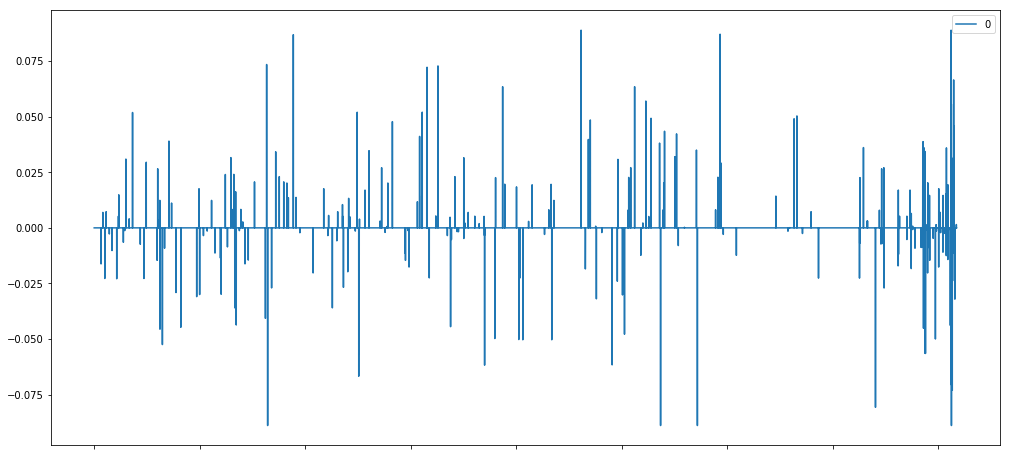

In [28]:
coefs = pd.DataFrame(W, index=dataset.columns)
coefs.plot(figsize=(17,8))

In [29]:
features = x[(x != 0)[0]].index.tolist()
len(features)

282

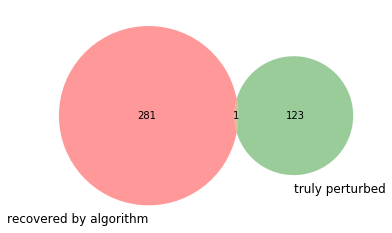

In [31]:
pathways_df = pd.read_pickle(KEGG_path)
genes, correlates = pathways_df.loc[pd.IndexSlice[:, :, ['hsa04110']],['genes', 'correlates']].values[0]
correlates = correlates.tolist()
venn2([set(features), set(genes)], ['recovered by algorithm', 'truly perturbed'])